In [29]:
#!/usr/bin/env python

# draft_structure_examle.ipynb

In [30]:
'''This program reads in W and Z data for a signle simulated case and
plots zoomed in maps of deep convective activity to showcase the 
how convective structures depend on horizontal grid spacing'''

'This program reads in W and Z data for a signle simulated case and\nplots zoomed in maps of deep convective activity to showcase the \nhow convective structures depend on horizontal grid spacing'

In [31]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.crs as ccrs

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import wrf


In [32]:
def disctance(lat1, lon1, lat2, lon2):
    from math import sin, cos, sqrt, atan2, radians

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Approximate radius of earth in km
    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    
    return distance

In [33]:
from draft_functions import core_2d_properties, core_3d_properties, \
                            watersheding, interpolate_obs, remove_noise

In [48]:
# DX = ['500M','250M','125M']
# DT = [2,1,0.5]
# dx_m = [500,250,125] 

DX_all = ['12KM','4KM','2KM','1KM','500M','250M','125M'] #,'obs']
colors = ['#1f78b4','#a6cee3','#33a02c','#ff7f00','#fb9a99','#e31a1c','k']
color_cortype = ['#e41a1c', '#377eb8', '#33a02c']
dx_km = [12,4,2,1,0.5,0.25,0.125]
DT_all = [64,16,8,4,2,1,0.5]
dx_m_all = [12000,4000,2000,1000,500,250,125]

SIM_All = ['mao_20140401_15:00:00_', #125
        'mao_20140917_17:00:00_',
        'mao_20141004_13:00:00_',
        'mao_20141018_14:00:00_',
        'mao_20141117_18:00:00_',
        'mao_20141210_14:00:00_',
        'mao_20150328_15:00:00_',
        'mao_20150412_12:00:00_',
        'mao_20150621_14:00:00_',
        'mao_20151106_12:00:00_', #125
        'sgp_20120531_04:00:00_',
        'sgp_20120615_07:00:00_', #125
        'sgp_20130509_07:00:00_',
        'sgp_20130605_09:00:00_',
        'sgp_20130617_07:00:00_',
        'sgp_20140602_04:00:00_',
        'sgp_20140605_12:00:00_',
        'sgp_20140612_06:00:00_', #125
        'sgp_20140628_16:00:00_',
        'sgp_20140710_10:00:00_']
si = 17 #17 # 9
SIM = SIM_All[si]
Site = SIM[:3].upper()

if si == 0:
    t_foc = 31
    zlev = 35
if si == 9:
    t_foc = 31
    zlev = 35
if si == 17:
    t_foc = 31
    zlev = 35
    

vwp_dir_obs = '/glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/data/RWP/' # SGP_RWP/'
vwp_dir = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/virtual_profiler_NetCDF/'
wrfout_dir = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/'

VARS = ['WW','QS','QR','QC','QG','QV','TK','P'] # virtual profiler variables

In [49]:
if Site == 'SGP':
    proj_File = '/glade/campaign/mmm/c3we/mingge/WRFV4.1.5_intel_dmpar/Thomson_YSU/sgp_20120531_04:00:00_L4/wrfout_d01_2012-05-30_04:00:00'
    extension = [-111, -88, 28, 48]
    ARMlon = -97.4882
    ARMlat = 36.6077
if Site == 'MAO':
    proj_File = '/glade/campaign/mmm/c3we/mingge/WRFV4.1.5_intel_dmpar/Thomson_YSU/mao_20150303_20:00:00_L4/wrfout_d01_2015-03-02_20:00:00'
    extension = [-69, -49, -13.5,6]
    ARMlon = -60.025
    ARMlat = -3.113

In [50]:
grDATA = {}
for dx in range(len(DX_all)):
    print(DX_all[dx])
    vwp_file = vwp_dir + SIM_All[si][:-1] + '/' + DX_all[dx] + '/'+ SIM_All[si]+ '_'+ DX_all[dx] +'_Loc01.nc'
    if os.path.isfile(vwp_file) == False:
        continue
    
    ncfile = Dataset(vwp_file)
    height = np.squeeze(ncfile.variables["Height"])
    time = np.squeeze(ncfile.variables['Time'])
    ncfile.close()
    
    # from datetime import timedelta
    from datetime import datetime, timedelta
    StartDay = datetime(int(SIM[4:8]), int(SIM[8:10]), int(SIM[10:12]), int(SIM[13:15])) - timedelta(hours=6)
    StopDay = StartDay  + timedelta(hours=12)
    if DT_all[dx] > 1:
        rgdTimeMCS = pd.date_range(StartDay, end=StopDay, freq=str(DT_all[dx])+'s') #'500ms')
    else:
        rgdTimeMCS = pd.date_range(StartDay, end=StopDay, freq=str(DT_all[dx])+'ms')
    rgdTimeMCS = rgdTimeMCS[:len(time)]

    DATA = np.zeros((len(time),len(height), 20, len(VARS))); DATA[:] = np.nan
    lat_vs = np.zeros((20)); lat_vs[:] = np.nan
    lon_vs = np.copy(lat_vs)

    for lo in tqdm(range(20)):  
        loc = str(lo+1).zfill(2)
        vwp_file = vwp_dir + SIM_All[si][:-1] + '/' + DX_all[dx] + '/'+ SIM_All[si]+ '_'+ DX_all[dx] +'_Loc' + loc + '.nc'
        ncfile = Dataset(vwp_file)
        
        lat_vs[lo] = ncfile.getncattr('profiler latitude')
        lon_vs[lo] = ncfile.getncattr('profiler longitude')
        for va in range(len(VARS)):
            # print('    '+VARS[va])
            DATA[:,:,lo,va] = np.squeeze(ncfile.variables[VARS[va]])
    grDATA[DX_all[dx]] = DATA

12KM
4KM
2KM
1KM
500M


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


250M


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


125M


100%|██████████| 20/20 [00:42<00:00,  2.15s/it]


In [51]:
# read the propagation speed of the observed MCSs
import xarray as xr
speed_sgp_file = '/glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/data/RWP/obs_movement-speed/sgprwpclsC1.c1.storms.nc'
ds_disk = xr.open_dataset(speed_sgp_file)

In [52]:
# plt.pcolormesh(rgdTimeMCS[t0:t1], height, DATA[t0:t1,:,11,0].T, vmin=-25, vmax=25, cmap='coolwarm')

### Read in RWP data for the case

In [53]:
speed_ca_median = 15

rwp_dir = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/ARM_DATA/RWP/'
files = glob.glob(rwp_dir + Site + '_ALL/*.cdf')
files_sel = files[np.where(np.array([SIM[4:12] in files[fi] for fi in range(len(files))]) == True)[0][-1]]

ncfile = Dataset(files_sel)
dbz_obs = np.squeeze(ncfile.variables["ReflectivityUAZR"][:]).T
w_obs = np.squeeze(ncfile.variables["VerticalVelocity"][:]).T
time_obs = np.squeeze(ncfile.variables["time_offset"][:])
obs_start = ncfile.variables["time_offset"].units
height_obs = np.squeeze(ncfile.variables["height"][:])
ncfile.close()

# create the time vector
obs_start = datetime(int(obs_start[14:18]), 
                      int(obs_start[19:21]), 
                      int(obs_start[22:24]),
                      int(obs_start[25:27]),
                      int(obs_start[28:30]))
obs_dt = np.mean(time_obs[1:] - time_obs[:-1])
obs_end = obs_start + timedelta(seconds=obs_dt*len(time_obs))
obs_time = pd.date_range(obs_start, end=obs_end, freq=str(obs_dt)[:1]+'s' + str(obs_dt)[2:4]+'ms')

filled_obs = interpolate_obs(w_obs)
# set grid cells that are more than two cells appard to nan again
nan_to_one = np.isnan(w_obs)
nan_to_one = np.apply_along_axis(lambda m: np.convolve(m, np.ones(5), mode='same'), axis=1, arr=nan_to_one)
filled_obs[nan_to_one >= 3] = np.nan

filled_obs_clean = remove_noise(filled_obs)
filled_obs_clean = interpolate_obs(filled_obs_clean)
filled_obs_clean[nan_to_one >= 3] = np.nan

time_to_length_obs = speed_ca_median * np.array(range(0,len(time_obs)))*6

### Read in W and Z at time t_foc

In [54]:
Data_3D = {}
for dx in tqdm(range(len(DX_all))):
    print(DX_all[dx])

    if np.isin(DX_all[dx], ('500M','250M','125M')) == True:
        subkm = True
    else:
        subkm = False

    if subkm == True:
        wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx]+'/Thomson_YSU/'+SIM+DX_all[dx]+'/wrfout_d02*'))
    else:
        if DX_all[dx] != '12KM':
            wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx]+'/Thomson_YSU/'+SIM+'L'+DX_all[dx][0]+'/wrfout_d01*'))
        else:
            wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx]+'/Thomson_YSU_0/'+SIM+'L'+DX_all[dx][:2]+'/wrfout_d01*'))
        # only focus the analysis on 18 - 30 hours 
        wrfout_files = wrfout_files[18*6+1:18*6+1+12*6]

    # read in key variables at t_foc
    ncfile = Dataset(wrfout_files[t_foc])
    lat = np.squeeze(ncfile.variables["XLAT"])
    lon = np.squeeze(ncfile.variables['XLONG'])
    dbz = np.squeeze(ncfile.variables["REFL_10CM"][:,:,:,:])
    ww = np.squeeze(ncfile.variables["W"][:,:,:,:])
    zz = np.squeeze(ncfile.variables["PHB"][:,:,:,:]) + np.squeeze(ncfile.variables["PH"][:,:,:,:])
    HGT = getvar(ncfile, "HGT")
    ncfile.close()

    data_act = {}
    data_act['lon'] = lon
    data_act['lat'] = lat
    data_act['ww'] = ww
    data_act['zz'] = zz
    data_act['dbz'] = dbz
    data_act['HGT'] = HGT
    
    Data_3D[DX_all[dx]] = data_act

  0%|          | 0/7 [00:00<?, ?it/s]

12KM


 14%|█▍        | 1/7 [00:00<00:03,  1.94it/s]

4KM


 29%|██▊       | 2/7 [00:02<00:06,  1.34s/it]

2KM


 43%|████▎     | 3/7 [00:10<00:16,  4.21s/it]

1KM


 57%|█████▋    | 4/7 [00:38<00:41, 13.86s/it]

500M


 71%|███████▏  | 5/7 [00:51<00:26, 13.33s/it]

250M


 86%|████████▌ | 6/7 [02:16<00:37, 37.68s/it]

125M


100%|██████████| 7/7 [07:58<00:00, 68.39s/it] 


### Plot the data

100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


        Plot map to: sgp_20140612_06:00:00__draft-examples.jpg


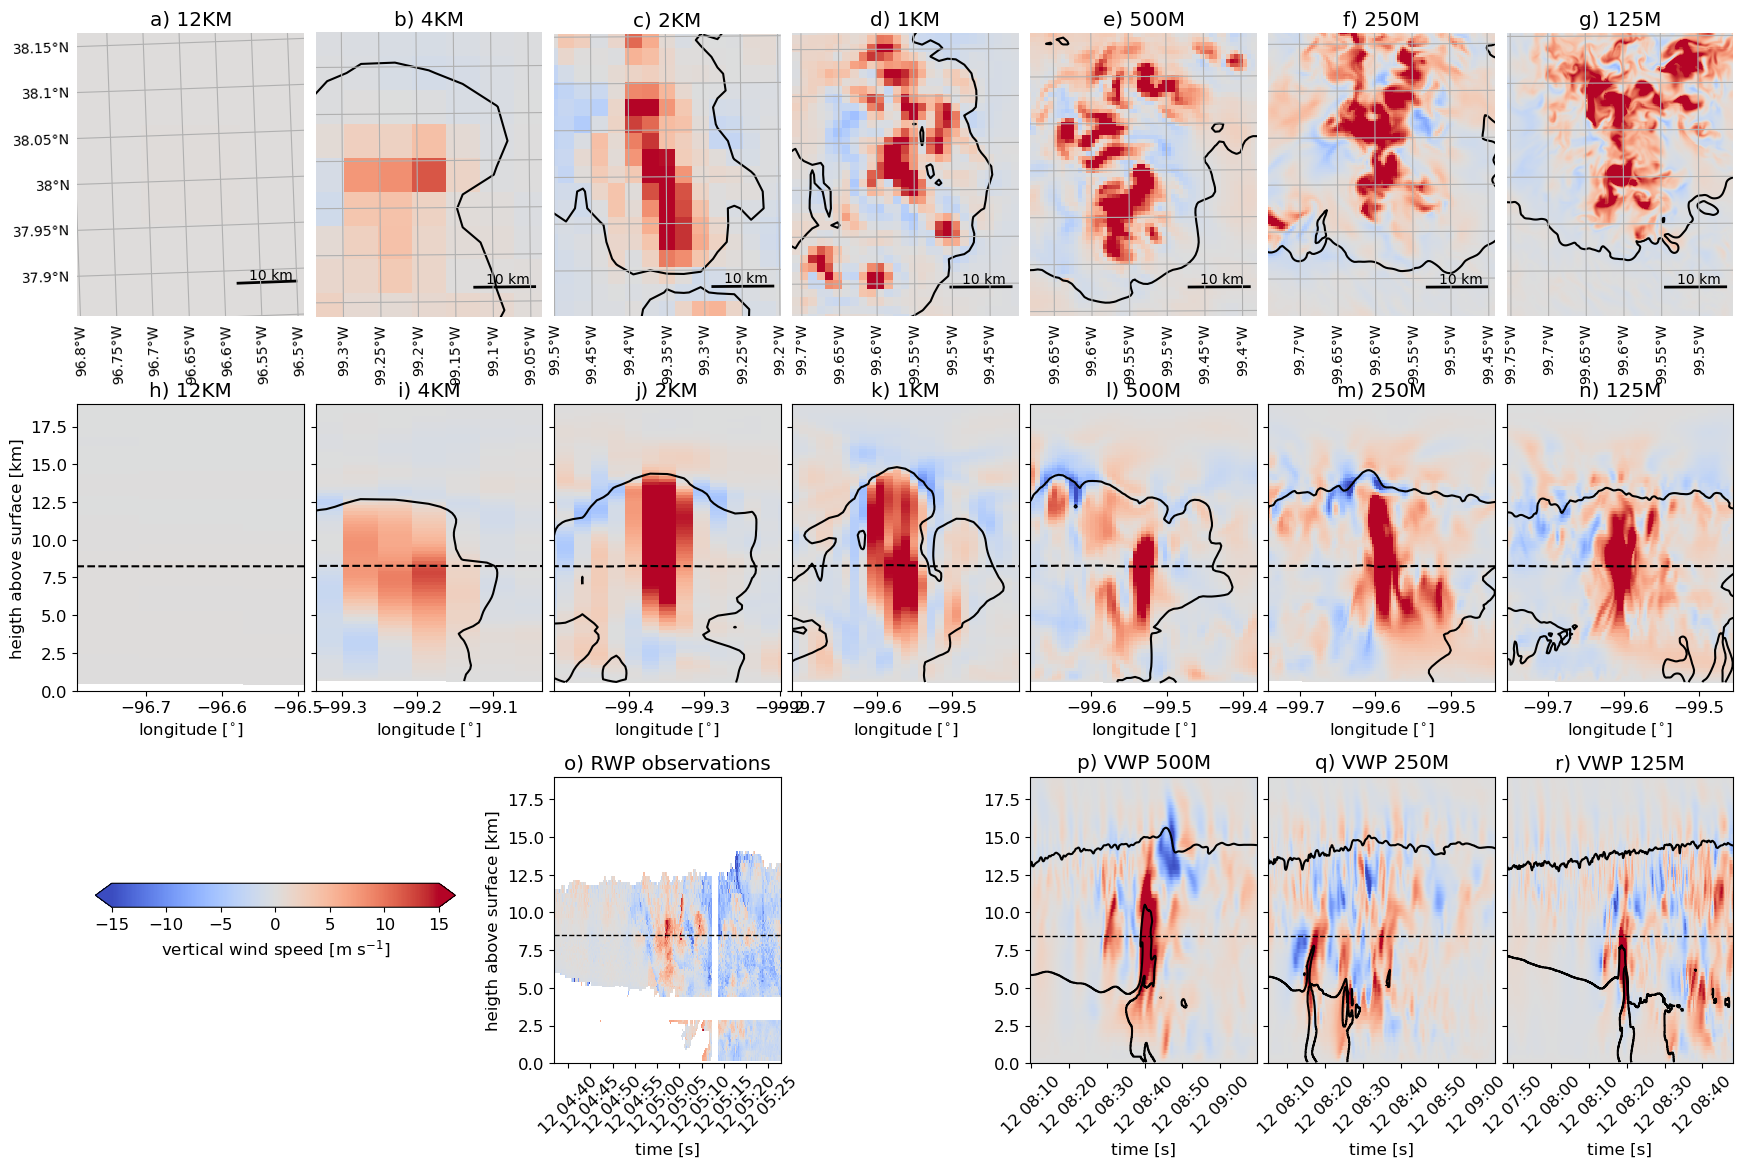

In [55]:
fig = plt.figure(figsize=(18,12))
gs1 = gridspec.GridSpec(3,len(DX_all))
gs1.update(left=0.04, right=0.96,
   bottom=0.07, top=0.93,
   wspace=0.05, hspace=0.30)
plt.rcParams.update({'font.size': 12})
abc_list = list(string.ascii_lowercase)
ylab = True
count = 0
dbz_lim = 20

# ========================================
# plot horizontal cross-sections
for dx in tqdm(range(7)): #tqdm(range(len(DX_all))):
    
    
    # find strongest updraft in 200 km radius arround ARM site
    dist = disctance(ARMlat, ARMlon,
                     Data_3D[DX_all[dx]]['lat'],Data_3D[DX_all[dx]]['lon'])
    dist = dist < 200
    ww_search = np.copy(Data_3D[DX_all[dx]]['ww'][zlev,:,:])
    ww_search[dist == 0] = 0
    max_ud = np.where(ww_search == np.max(ww_search[dist]))

    foc_lon = Data_3D[DX_all[dx]]['lon'][max_ud[0][0], max_ud[1][0]]
    foc_lat = Data_3D[DX_all[dx]]['lat'][max_ud[0][0], max_ud[1][0]]
    
    HGT = Data_3D[DX_all[dx]]['HGT']
    proj = get_cartopy(HGT)
    
    # =====================================
    # Horizontal cross section through drafts
    ax = plt.subplot(gs1[0,dx], projection=proj)
    mar = 0.15
    ax.set_extent([foc_lon-mar,foc_lon+mar,foc_lat-mar,foc_lat+mar], ccrs.Geodetic())
    plt.pcolormesh(Data_3D[DX_all[dx]]['lon'],
                  Data_3D[DX_all[dx]]['lat'],
                  Data_3D[DX_all[dx]]['ww'][zlev,:,:],
                  vmin=-20, vmax=20, cmap='coolwarm', 
                  transform=ccrs.PlateCarree())
    plt.contour(Data_3D[DX_all[dx]]['lon'],
                  Data_3D[DX_all[dx]]['lat'],
                  Data_3D[DX_all[dx]]['dbz'][zlev,:,:],
                  levels = [dbz_lim], colors='k', linestyles = '-', 
                  transform=ccrs.PlateCarree())
    ax.coastlines()
    
    plt.plot([foc_lon+mar/2.5, foc_lon+mar/2.5+0.08],
             [foc_lat-mar/1.25, foc_lat-mar/1.25],
              c='k', lw = 2, transform=ccrs.PlateCarree())
    plt.text(foc_lon+mar/2,foc_lat-mar/1.26, '10 km',
             va='bottom', ha = 'left', transform=ccrs.PlateCarree(), fontsize = 10)
    
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.ylabel_style = {'size': 10}
    gl.xlabel_style = {'size': 10}
    gl.top_labels=False
    gl.right_labels=False
    if dx > 0:
        gl.left_labels=False
    
    # plot ARM location
    ax.plot(ARMlon,ARMlat,'ko', transform=ccrs.PlateCarree(), markersize=5)
    plt.title(abc_list[dx]+') '+DX_all[dx])
    ax.axis('off')
    
    
    # =====================================
    # Vertical cross section through drafts
    ax = plt.subplot(gs1[1,dx])
    
    plt.pcolormesh(Data_3D[DX_all[dx]]['lon'][max_ud[0][0],:],
                  (Data_3D[DX_all[dx]]['zz'][:,max_ud[0][0],:]/9.81)/1000.,
                  Data_3D[DX_all[dx]]['ww'][:,max_ud[0][0],:],
                  vmin=-20, vmax=20, cmap='coolwarm')
    plt.contour(np.tile(Data_3D[DX_all[dx]]['lon'][max_ud[0][0],:], (Data_3D[DX_all[dx]]['dbz'].shape[0], 1)),
                  (Data_3D[DX_all[dx]]['zz'][:-1,max_ud[0][0],:]/9.81)/1000.,
                  Data_3D[DX_all[dx]]['dbz'][:,max_ud[0][0],:],
                  levels = [dbz_lim], colors='k', linestyles = '-')
    
    plt.xlim(foc_lon-mar, foc_lon+mar)
    plt.ylim(0,19)
    if dx > 0:
        ax.set_yticklabels([])
    plt.plot(Data_3D[DX_all[dx]]['lon'][max_ud[0][0],:],
             ((Data_3D[DX_all[dx]]['zz'][zlev,max_ud[0][0],:]/9.81)/1000.),
             color = 'k', ls='--')
    
    plt.title(abc_list[dx+len(DX_all)]+') '+DX_all[dx])
    if dx == 0:
        plt.ylabel('heigth above surface [km]')
    plt.xlabel('longitude [$^{\circ}$]')
    
    # =====================================
    # virtual wind profiler
    try:
        ax = plt.subplot(gs1[2,dx])
        StartDay = datetime(int(SIM[4:8]), int(SIM[8:10]), int(SIM[10:12]), int(SIM[13:15])) - timedelta(hours=6)
        StopDay = StartDay  + timedelta(hours=12)
        if DT_all[dx] >= 1:
            rgdTimeMCS = pd.date_range(StartDay, end=StopDay, freq=str(DT_all[dx])+'s') #'500ms')
        else:
            rgdTimeMCS = pd.date_range(StartDay, end=StopDay, freq=str(DT_all[dx]*1000)+'ms') #'500ms')
        rgdTimeMCS = rgdTimeMCS[:len(time)]
        # time_vp = (rgdTimeMCS <= (time_ca + timedelta(minutes=timewindow))[0]) & (rgdTimeMCS >= (time_ca - timedelta(minutes=timewindow))[0])  

        # scan locations for strongest updraft
        data_vp = grDATA[DX_all[dx]]
        max_ww = np.zeros((data_vp.shape[2],2)); max_ww[:] = np.nan
        for lo in range(data_vp.shape[2]):
            max_ww[lo,0] = np.max(data_vp[:,zlev,lo,VARS.index('WW')])
            max_ww[lo,1] = np.argmax(data_vp[:,zlev,lo,VARS.index('WW')])
        loc_max = np.argmax(max_ww[:,0])
        tt_max = int(max_ww[loc_max,1])

        wrf_dbz_column = wrf.dbz(data_vp[:,:,loc_max,VARS.index('P')][None,:], 
                                data_vp[:,:,loc_max,VARS.index('TK')][None,:], 
                                data_vp[:,:,loc_max,VARS.index('QV')][None,:], 
                                data_vp[:,:,loc_max,VARS.index('QR')][None,:], 
                                qs=data_vp[:,:,loc_max,VARS.index('QS')][None,:], 
                                qg=data_vp[:,:,loc_max,VARS.index('QG')][None,:],
                                use_varint = True,
                                use_liqskin=True)

        margin = int(30*60/DT_all[dx])

        cs = plt.pcolormesh(rgdTimeMCS[:wrf_dbz_column.shape[1]][tt_max-margin:tt_max+margin],
                       height/1000.,
                       data_vp[tt_max-margin:tt_max+margin,:,loc_max,VARS.index('WW')].T,
                      cmap='coolwarm', vmin=-15,vmax=15)
        plt.contour(rgdTimeMCS[:wrf_dbz_column.shape[1]][tt_max-margin:tt_max+margin],
                       height/1000.,
                       wrf_dbz_column[0,tt_max-margin:tt_max+margin,:].T,
                      colors='k', levels = [dbz_lim], linestyles = '-')
        plt.xticks(rotation=45)
        plt.axhline(y=height[zlev]/1000., linewidth=1, color='k', ls='--')
        if ylab == False:
            ax.set_yticklabels([])
            # plt.ylabel('heigth [km]')
        plt.ylim(0,19)
        plt.xlabel('time [s]')
        plt.title(abc_list[count+len(DX_all)*2+1]+') VWP '+DX_all[dx])
        count = count +1
        

        ylab = False
    except:
        ax.axis('off')
        continue
        
# ====================================
# PLOT RWP DATA FROM THIS CASE
ax = plt.subplot(gs1[2,2])
ax.axis('on')

sel_lev = np.argmin(np.abs(height_obs - height[zlev]/1000.))
rwp_maxdraft = np.nanargmax(filled_obs_clean[sel_lev,:])
margin = int(30*60/6)

plt.pcolormesh(obs_time[rwp_maxdraft-margin:rwp_maxdraft+margin], 
               height_obs, 
               filled_obs_clean[:,rwp_maxdraft-margin:rwp_maxdraft+margin],
               cmap='coolwarm', vmin=-15,vmax=15)
plt.xticks(rotation=45)
plt.axhline(y=height_obs[sel_lev], linewidth=1, color='k', ls='--')
plt.title(abc_list[len(DX_all)*2]+') RWP observations')

plt.ylabel('heigth above surface [km]')
plt.xlabel('time [s]')
plt.ylim(0,19)

# ====================================  
# plot colot table
CbarAx = plt.axes([0.05, 0.2, 0.2, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=Levels)
cb.set_label('vertical wind speed [m s$^{-1}$]', fontsize=12)


sPlotFile=''
sPlotName= SIM+'_draft-examples.jpg'
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)

plt.show()

In [ ]:
stop()

--Call--
> /glade/work/prein/conda-envs/python_202401/lib/python3.11/site-packages/IPython/core/displayhook.py(258)__call__()
    256         sys.stdout.flush()
    257 
--> 258     def __call__(self, result=None):
    259         """Printing with history cache management.
    260 



In [ ]:
DX_all[dx]

In [ ]:
time_to_length_obs[rwp_maxdraft-margin:rwp_maxdraft+margin].shape

In [ ]:
filled_obs_clean[rwp_maxdraft-margin:rwp_maxdraft+margin,:].shape

In [ ]:
filled_obs_clean.shape

In [ ]:
((Data_3D[DX_all[dx]]['zz'][:-1,max_ud[0][0],:]/9.81)/1000.).shape

In [ ]:
lat1 = np.radians(ARMlat)
lon1 = np.radians(ARMlon)
lat2 = np.radians(Data_3D[DX_all[dx]]['lat'])
lon2 = np.radians(Data_3D[DX_all[dx]]['lon'])


R = 6373.0

dlon = lon2 - lon1
dlat = lat2 - lat1

aa = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
cc = 2 * np.arctan2(np.sqrt(aa), np.sqrt(1 - aa))

distance = R * cc


In [ ]:
distance

In [ ]:
wrfout_files = np.sort(glob.glob(wrfout_dir+DX[dx]+'/Thomson_YSU/'+SIM+DX_all[dx]+'/wrfout_d02*'))
ncfile = Dataset(wrfout_files[0])
lat = np.squeeze(ncfile.variables["XLAT"])
lon = np.squeeze(ncfile.variables['XLONG'])
ncfile.close()

In [ ]:
dbz = np.zeros((len(wrfout_files), lat.shape[0], lat.shape[1])); dbz[:] = np.nan
for tt in tqdm(range(len(wrfout_files))):
    ncfile = Dataset(wrfout_files[tt])
    dbz[tt,:,:] = np.squeeze(ncfile.variables["REFL_10CM"][0,20,:,:])
    ncfile.close()

In [ ]:
# create time vector for wrfout files
import wrf
ncfile = Dataset(wrfout_files[0])
start_wrfout = wrf.extract_times(ncfile,0)
ncfile = Dataset(wrfout_files[-1])
stop_wrfout = wrf.extract_times(ncfile,0)

time_wrfout = pd.date_range(start_wrfout, end=stop_wrfout, freq='10min') #'500ms')

### Track high-reflectivity areas and determine their speed

In [ ]:
idbz_threshold = 40
MinObjVolume = 4000000 # m2
iSmooth = 16000
rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1

iSmoothGC=int(iSmooth/dx_m[dx])
dbz_smooth=scipy.ndimage.uniform_filter(dbz[:,:,:],[1,iSmoothGC,iSmoothGC])

# threshold the dbz
rgiTH_dbz=(dbz_smooth >= idbz_threshold)
rgrdbz_thresholded=np.copy(dbz)
rgrdbz_thresholded[rgiTH_dbz == False]=0
rgiObjectsUD, nr_objectsUD = ndimage.label(rgiTH_dbz,structure=rgiObj_Struct)

# sort the objects according to their size
Objects=ndimage.find_objects(rgiObjectsUD)
rgiVolObj=np.array([np.sum(rgiObjectsUD[Objects[ob]] == ob+1) for ob in range(nr_objectsUD)])
rgiObBySize=np.array([np.where(np.sort(rgiVolObj)[::-1][ob] == rgiVolObj)[0][0] for ob in range(nr_objectsUD)])
rgiObBySize=rgiObBySize[rgiVolObj[rgiObBySize] >= MinObjVolume]

# create final object array
dbz_objects=np.copy(rgiObjectsUD); dbz_objects[:]=0
for ob in range(len(rgiObBySize)):
    dbz_objects[rgiObjectsUD == (rgiObBySize[ob]+1)] = ob+1
    


In [ ]:
print('        break up long living cores')
from Tracking_Functions import BreakupObjects
MS_objects, object_split = BreakupObjects(dbz_objects,
                            3/6.,
                            1/6.)

In [ ]:
plt.pcolormesh(dbz_objects[35,:,:])

In [ ]:
from Tracking_Functions import calc_grid_distance_area
from Tracking_Functions import calc_object_characteristics
_,_,Area,Gridspacing = calc_grid_distance_area(lon,lat)

cell_obj_characteristics = calc_object_characteristics(MS_objects.astype('int'), # feature object file
                                     dbz,         # original file used for feature detection
                                     'tmp/cell_stats.pkl',
                                     rgdTimeMCS,            # timesteps of the data
                                     lat,             # 2D latidudes
                                     lon,             # 2D Longitudes
                                     Gridspacing,
                                     Area,
                                     min_tsteps=3,
                                     split_merge = 0)

In [ ]:
# get cores that intersect with virtual sounding locations

# get location of vs in grid
from Tracking_Functions import radialdistance
lat_vs_id = np.copy(lat_vs); lat_vs_id[:] = np.nan
lon_vs_id = np.copy(lat_vs_id)
for ii in tqdm(range(len(lat_vs))):
    mindist = radialdistance(lat,lon,lat_vs[ii],lon_vs[ii])
    min_loc = np.argwhere(mindist == np.min(mindist))[0]
    lat_vs_id[ii] = min_loc[0]
    lon_vs_id[ii] = min_loc[1]

lat_vs_id = lat_vs_id.astype('int')
lon_vs_id = lon_vs_id.astype('int')

In [ ]:
dist = 60000 # m -- distance to extract arround the station
timewindow = 40 # minutes arround 2D obs
dx_dist = int(dist/dx_m[dx])

cores_vp_up = {}
cores_vp_up_obs = {}
cores_2d_up = {}
cores_3d_up = {}
cores_vp_down = {}
cores_vp_down_obs = {}
cores_2d_down = {}
cores_3d_down = {}

ud_min = 1.5
dd_min = 1.5
draft_th = [1.5,3.0,6.0,10.0]

direction = ['up', 'down']  # [ up - updraft; down - downdraft]

# loop over virtual profilers
for ii in [0]: #tqdm(range(len(lat_vs))):
    conv_inters = np.unique(MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])[1:]
    la_start = lat_vs_id[ii] - dx_dist
    la_stop = lat_vs_id[ii] + dx_dist + 1
    lo_start = lon_vs_id[ii] - dx_dist
    lo_stop = lon_vs_id[ii] + dx_dist +1

    location = 'loc-'+str(ii).zfill(2)

    # virtual profiler data
    data_vp = grDATA[DX[dx]][:,:,ii,:]

    for ca in range(len(conv_inters)):
        conv_element = 'conv-'+str(ca).zfill(3)
        files_int = wrfout_files[conv_inters[ca] == (MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])]
        speed_ca_median = np.median(cell_obj_characteristics[str(conv_inters[ca])]['speed'])
        for fi in [0]: #range(len(files_int)):
            file_act = 'output-'+str(fi).zfill(2)
            ncfile = Dataset(files_int[fi])
            dbz_ca = np.squeeze(ncfile.variables["REFL_10CM"][0,:,la_start:la_stop,lo_start:lo_stop])
            w_ca = np.squeeze(ncfile.variables["W"][0,:,la_start:la_stop,lo_start:lo_stop])
            z_ca_stag = (np.squeeze(ncfile.variables["PHB"][0,:,la_start:la_stop,lo_start:lo_stop]) + \
                    np.squeeze(ncfile.variables["PH"][0,:,la_start:la_stop,lo_start:lo_stop])) / 9.81 - \
                    np.squeeze(ncfile.variables["HGT"][0,la_start:la_stop,lo_start:lo_stop])
            z_ca = (z_ca_stag[1:,:] + z_ca_stag[:-1,:])/2
            # brind 3D data to common grid
            dbz_ca_comz = wrf.interpz3d(dbz_ca, z_ca, height, missing = np.nan)
            w_ca_comz = wrf.interpz3d(w_ca, z_ca_stag, height, missing = np.nan)
            ncfile.close()

            # degrees to meters
            lon_m = np.linspace(0,Gridspacing*w_ca.shape[1], w_ca.shape[1]); lon_m = lon_m - np.mean(lon_m)
            lat_m = np.copy(lon_m)

            cloudmask = np.copy(dbz_ca_comz[:,dx_dist,:]); cloudmask[:] = 1
            cloudmask[0,:] = np.nan
            cloudmask[-1,:] = np.nan
            cloudmask[dbz_ca_comz[:,dx_dist,:] <= -30] = np.nan
            
            cloudmask_3d = np.copy(dbz_ca_comz[:,:,:]); cloudmask_3d[:] = 1
            cloudmask_3d[dbz_ca_comz[:,:,:] <= -30] = np.nan

#             plt.pcolormesh(lon_m/1000., height, w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
#             plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] > 5, colors = 'r')
#             plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] < -5, colors = 'b')
#             plt.contour(lon_m/1000., height, 
#                            cloudmask > 0,
#                         colors='k')
#             plt.show()
            
#             stop()

            for di in range(len(direction)):
                if direction[di] == 'up':
                    dire_sign = 1
                elif direction[di] == 'down':
                    dire_sign = -1

                for th in range(len(draft_th)):
                    # WORKING ON 2D CORES
                    updrafts = w_ca_comz[:,dx_dist,:]  * dire_sign > draft_th[th]
                    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])

                    w_2D = np.copy(w_ca_comz[:,dx_dist,:]) * dire_sign
                    
                    # watershedding
                    rgiObjectsUD = watersheding(rgiObjectsUD, 
                                                w_2D,
                         int(4000/dx_m[dx]),
                         1)
                    # sort the objects according to their size
                    Objects=ndimage.find_objects(rgiObjectsUD)
                                        
                    if direction[di] == 'up':
                        cores_2d_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                      w_2D,
                                      cloudmask,
                                      height,
                                      lon_m)
                    elif direction[di] == 'down':
                        cores_2d_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                      w_2D,
                                      cloudmask,
                                      height,
                                      lon_m)

                        
                    #  WORK ON 3D CORES
                    updrafts = w_ca_comz[:,:,:]  * dire_sign > draft_th[th]
                    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[:,:,:])
                    
                    w_3D = np.copy(w_ca_comz[:,:,:]) * dire_sign
                    w_3D[np.isnan(cloudmask_3d)] = np.nan
                    
                    # watershedding
                    rgiObjectsUD = watersheding(rgiObjectsUD, 
                                                w_3D,
                                                 int(4000/dx_m[dx]),
                                                 1)
                    # sort the objects according to their size
                    Objects=ndimage.find_objects(rgiObjectsUD)

                    rgiObjectsUD = rgiObjectsUD.astype(float)
                    rgiObjectsUD[np.isnan(cloudmask_3d)] = np.nan

                    if direction[di] == 'up':
                        cores_3d_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_3d_properties(w_3D,
                                          rgiObjectsUD,
                                          Objects,
                                          height,
                                          lat_m,
                                          lon_m)
                    elif direction[di] == 'down':
                        cores_3d_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_3d_properties(w_3D,
                                          rgiObjectsUD,
                                          Objects,
                                          height,
                                          lat_m,
                                          lon_m)

                    
                        
        # ---------------------------------------------
        # calculate properties from virtual profiler
        time_ca = time_wrfout[conv_inters[ca] == (MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])]
        time_vp = (rgdTimeMCS <= (time_ca + timedelta(minutes=timewindow))[0]) & (rgdTimeMCS >= (time_ca - timedelta(minutes=timewindow))[0])  
        time_to_length = range(0,sum(time_vp), DT[dx]) * speed_ca_median

        wrf_dbz_column = wrf.dbz(data_vp[time_vp,:,VARS.index('P')][None,:], 
                        data_vp[time_vp,:,VARS.index('TK')][None,:], 
                        data_vp[time_vp,:,VARS.index('QV')][None,:], 
                        data_vp[time_vp,:,VARS.index('QR')][None,:], 
                        qs=data_vp[time_vp,:,VARS.index('QS')][None,:], 
                        qg=data_vp[time_vp,:,VARS.index('QG')][None,:],
                        use_varint = True,
                        use_liqskin=True)

        # plt.pcolormesh(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T, vmin=-25, vmax=25, cmap='coolwarm')
        # plt.contour(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T > draft_th[th], colors = 'r')
        # plt.contour(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T < -draft_th[th], colors = 'b')
        # plt.contour(time_to_length/1000., height, 
        #                cloudmask[:,:].T > 0, 
        #             colors='k')
        # plt.show()

        for th in range(len(draft_th)):
            for di in range(len(direction)):
                if direction[di] == 'up':
                    dire_sign = 1
                elif direction[di] == 'down':
                    dire_sign = -1

                # virtual profiler draft characteristics
                updrafts = data_vp[time_vp,:,VARS.index('WW')].T * dire_sign
                
                # we have to aggregate the temporal data to a similar resolution as the spatial
                # data to get the same watersheding characteristics
                intervals = int(time_to_length.max()/dx_m[dx])
                bins_per_int = int(updrafts.shape[1]/intervals)
                updrafts = np.copy(updrafts[:, :intervals * bins_per_int])
                updrafts = np.mean(np.reshape(updrafts, 
                                          (updrafts.shape[0], intervals, bins_per_int)), axis = 2)
                updrafts_th = updrafts > draft_th[th]
                
                cloudmask = np.copy(DATA[time_vp,:,ii,VARS.index('WW')]); cloudmask[:] = 1
                cloudmask[0,:] = np.nan
                cloudmask[-1,:] = np.nan
                cloudmask[wrf_dbz_column[0] <= -30] = np.nan
                cloudmask = np.copy(cloudmask.T[:, :intervals * bins_per_int])
                cloudmask = np.mean(np.reshape(cloudmask, 
                                          (cloudmask.shape[0], intervals, bins_per_int)), axis = 2)
                
                rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts_th,structure=rgiObj_Struct[0,:,:])
                # watershedding
                rgiObjectsUD = watersheding(rgiObjectsUD, 
                                            updrafts,
                                             int(4000/dx_m[dx]),
                                             1)
                # sort the objects according to their size
                Objects=ndimage.find_objects(rgiObjectsUD)

                # w_2D = np.copy(data_vp[time_vp,:,VARS.index('WW')].T)* dire_sign
                # # get w_2D to dx resolution
                # w_2D = np.copy(w_2D[:, :intervals * bins_per_int])
                # updrafts = np.mean(np.reshape(updrafts, 
                #                           (updrafts.shape[0], intervals, bins_per_int)), axis = 2)
                if direction[di] == 'up':
                    cores_vp_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                  updrafts,
                                  cloudmask,
                                  height,
                                  time_to_length[::bins_per_int][:rgiObjectsUD.shape[1]])
                elif direction[di] == 'down':
                    cores_vp_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                  updrafts,
                                  cloudmask,
                                  height,
                                  time_to_length[::bins_per_int])
 

        # # ---------------------------------------------
        # # calculate properties from RWP        
        obs_file = glob.glob(vwp_dir_obs + SIM[:3].upper() + '_RWP/*'+SIM[4:12]+'*')[0]
        ncfile = Dataset(obs_file)
        dbz_obs = np.squeeze(ncfile.variables["ReflectivityUAZR"][:]).T
        w_obs = np.squeeze(ncfile.variables["VerticalVelocity"][:]).T
        time_obs = np.squeeze(ncfile.variables["time_offset"][:])
        obs_start = ncfile.variables["time_offset"].units
        height_obs = np.squeeze(ncfile.variables["height"][:])
        ncfile.close()
        
        # create the time vector
        obs_start = datetime(int(obs_start[14:18]), 
                              int(obs_start[19:21]), 
                              int(obs_start[22:24]),
                              int(obs_start[25:27]),
                              int(obs_start[28:30]))
        obs_dt = np.mean(time_obs[1:] - time_obs[:-1])
        obs_end = obs_start + timedelta(seconds=obs_dt*len(time_obs))
        obs_time = pd.date_range(obs_start, end=obs_end, freq=str(obs_dt)[:1]+'s' + str(obs_dt)[2:4]+'ms')
        
        filled_obs = interpolate_obs(w_obs)
        # set grid cells that are more than two cells appard to nan again
        nan_to_one = np.isnan(w_obs)
        nan_to_one = np.apply_along_axis(lambda m: np.convolve(m, np.ones(5), mode='same'), axis=1, arr=nan_to_one)
        filled_obs[nan_to_one >= 3] = np.nan
        
        filled_obs_clean = remove_noise(filled_obs)
        filled_obs_clean = interpolate_obs(filled_obs_clean)
        filled_obs_clean[nan_to_one >= 3] = np.nan
        
        time_to_length_obs = speed_ca_median * np.array(range(0,len(time_obs)))*6
        
        for th in range(len(draft_th)):
            for di in range(len(direction)):
                if direction[di] == 'up':
                    dire_sign = 1
                elif direction[di] == 'down':
                    dire_sign = -1

                # virtual profiler draft characteristics
                updrafts = np.copy(filled_obs_clean) * dire_sign

                # we have to aggregate the temporal data to a similar resolution as the spatial
                # data to get the same watersheding characteristics
                intervals = int(time_to_length_obs.max()/dx_m[dx])
                bins_per_int = int(updrafts.shape[1]/intervals)
                updrafts = np.copy(updrafts[:, :intervals * bins_per_int])
                updrafts = np.mean(np.reshape(updrafts, 
                                          (updrafts.shape[0], intervals, bins_per_int)), axis = 2)
                updrafts_th = updrafts > draft_th[th]

                cloudmask = np.copy(filled_obs_clean); cloudmask[:] = 1
                cloudmask[0,:] = np.nan
                cloudmask[-1,:] = np.nan
                cloudmask[np.isnan(filled_obs_clean)] = np.nan
                cloudmask = np.copy(cloudmask[:, :intervals * bins_per_int])
                cloudmask = np.mean(np.reshape(cloudmask, 
                                          (cloudmask.shape[0], intervals, bins_per_int)), axis = 2)

                rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts_th,structure=rgiObj_Struct[0,:,:])
                # watershedding
                rgiObjectsUD = watersheding(rgiObjectsUD, 
                                            updrafts,
                                             int(4000/dx_m[dx]),
                                             1)
                # sort the objects according to their size
                Objects=ndimage.find_objects(rgiObjectsUD)

                # w_2D = np.copy(data_vp[time_vp,:,VARS.index('WW')].T)* dire_sign
                # # get w_2D to dx resolution
                # w_2D = np.copy(w_2D[:, :intervals * bins_per_int])
                # updrafts = np.mean(np.reshape(updrafts, 
                #                           (updrafts.shape[0], intervals, bins_per_int)), axis = 2)
                if direction[di] == 'up':
                    cores_vp_up_obs[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                  updrafts,
                                  cloudmask,
                                  height,
                                  time_to_length[::bins_per_int][:rgiObjectsUD.shape[1]])
                elif direction[di] == 'down':
                    cores_vp_down_obs[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  rgiObjectsUD,
                                  updrafts,
                                  cloudmask,
                                  height,
                                  time_to_length[::bins_per_int])
                    
        stop()

In [ ]:
plt.pcolormesh(rgiObjectsUD[:,:]>0)

In [ ]:
rgiObjectsUD

In [ ]:
Objects

In [ ]:
plt.pcolormesh(updrafts[:,400:1000], cmap='coolwarm', vmin=-10, vmax=10)
plt.contour(rgiObjectsUD[:,400:1000], colors='k', linewidths = 0.1)

In [ ]:
plt.pcolormesh(time_to_length_obs/1000., height_obs,
               filled_obs_clean[:,:], 
               cmap='coolwarm', vmin=-10, vmax=10)
plt.xlim([120,170])
plt.show()


In [ ]:
sim_draft = np.copy(updrafts)
sim_draft[cloudmask!=1] = np.nan

plt.pcolormesh(time_to_length[::bins_per_int][:rgiObjectsUD.shape[1]]/1000, 
               height,
               sim_draft, 
               cmap='coolwarm', vmin=-10, vmax=10)
plt.show()

In [ ]:
cloudmask.shape

In [ ]:
grad_2d[0]

In [ ]:
plt.pcolormesh(w_3D[30,200:300,200:300])

In [ ]:
plt.pcolormesh(rgiObjectsUD)

In [ ]:
plt.pcolormesh(rgiObjectsUD[30,200:300,200:300])

In [ ]:
plt.pcolormesh(rgiObjectsUD[:60,250,:], cmap='coolwarm')

In [ ]:
plt.pcolormesh(w_3D[:60,250,:], cmap='coolwarm', vmin=-20, vmax=20)

In [ ]:
plt.pcolormesh(w_3D[30,:,:], cmap='coolwarm', vmin=-20, vmax = 20)

In [ ]:
plt.pcolormesh(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T, vmin=-25, vmax=25, cmap='coolwarm')
plt.contour(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T > draft_th[th], colors = 'r')
plt.contour(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T < -draft_th[th], colors = 'b')
plt.contour(time_to_length/1000., height, 
               cloudmask[:,:] > 0, 
            colors='k')
plt.show()

In [ ]:
plt.pcolormesh(lon_m/1000., height, w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] > 3, colors = 'r')
plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] < -3, colors = 'b')
# plt.contour(lon_m/1000., height, 
#                cloudmask > 0,
#             colors='k')
plt.axhline(y=height[40], color='k', linestyle='-')

In [ ]:
hh = 30
plt.pcolormesh(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:], vmin=-25, vmax=25, cmap='coolwarm')
# plt.contour(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:] > 3, colors = 'r')
# plt.contour(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:] < -3, colors = 'b')
plt.axhline(y=0, color='k', linestyle='-')

### Plot 3D watersheding example

In [ ]:
import numpy as np
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from scipy import ndimage

tt=30
image = w_ca_comz[:,:,:] > 3
lat_cut = np.argmin(np.abs(lon_m/1000. - 25))

distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(
    distance, footprint=np.ones((3, 3, 3)), labels=np.array(image),
    min_distance=int(4000/dx_m[dx]), threshold_abs=1) # , indices=False

peaks_mask = np.zeros_like(distance, dtype=bool)
peaks_mask.T[local_maxi] = True

markers = ndimage.label(peaks_mask)[0]

labels = watersheding(np.array(image),  # 2D or 3D matrix with labeled objects [np.array]
                 np.array(w_ca_comz[:,:,:]), # vertical wind field
                   int(4000/dx_m[dx]),      # minimum distance between two objects [int]
                   1)


# # markers = ndimage.label(local_maxi)[0]
# labels_orig = watershed(-distance, markers, mask=image)
labels = np.copy(labels.astype(float))
labels[labels == 0] = np.nan


mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 15})

print('start plotting')

fig = plt.figure(figsize=(14,15))
# Histogram plots
gs1 = gridspec.GridSpec(3,3) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.15, hspace=0.25)

ax = plt.subplot(gs1[0,0])
plt.pcolormesh(lat_m/1000., lon_m/1000., image[tt,:,:]*-1, cmap='gray')
plt.plot([10,40,40,10,10], [40,40,10,10,40], c='r')
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.title('a) updraft mask')
ax.set_xlabel('Longitude [km]')
ax.set_ylabel('latitude [km]')

ax = plt.subplot(gs1[0,1])
plt.pcolormesh(lat_m/1000., lon_m/1000., w_ca_comz[tt,:,:], vmin=-35, vmax=35, cmap='coolwarm')
plt.plot([10,40,40,10,10], [40,40,10,10,40], c='r')
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.title('b) vertical wind speed')

ax = plt.subplot(gs1[0,2])
plt.pcolormesh(lat_m/1000., lon_m/1000., labels[tt,:,:], cmap=plt.cm.nipy_spectral, vmin=0, vmax=480)
plt.plot([10,40,40,10,10], [40,40,10,10,40], c='r')
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.title('c) core segmentation')

# --------------------------------------------
print('    ZOOM INTO CONVECTIVE RETION')
tt1 = tt - 0
ax = plt.subplot(gs1[1,0])
plt.pcolormesh(lat_m/1000., lon_m/1000., image[tt1,:,:]*-1, cmap='gray')
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.xlim(10, 40)
plt.ylim(10, 40)
plt.title('d) updraft mask zoom in')

ax = plt.subplot(gs1[1,1])
plt.pcolormesh(lat_m/1000., lon_m/1000., w_ca_comz[tt1,:,:], vmin=-35, vmax=35, cmap='coolwarm')
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.xlim(10, 40)
plt.ylim(10, 40)
plt.contour(lat_m/1000., lon_m/1000., labels[tt1,:,:], cmap=plt.cm.nipy_spectral)
plt.title('e) vertical wind speed zoom in')

ax = plt.subplot(gs1[1,2])
plt.pcolormesh(lat_m/1000., lon_m/1000., labels[tt1,:,:], cmap=plt.cm.nipy_spectral, vmin=0, vmax=480)
plt.plot([0,55], [lon_m[lat_cut]/1000, lon_m[lat_cut]/1000], c='k', ls='--')
plt.xlim(10, 40)
plt.ylim(10, 40)
plt.title('f) core segmentation zoom in')


# --------------------------------------------
print('    VERTICAL CROSS SECTION')


ax = plt.subplot(gs1[2,0])
plt.pcolormesh(lon_m/1000., height/1000, image[:,lat_cut,:]*-1, cmap='gray')
plt.axhline(y=height[tt]/1000, color='k', linestyle='--')
plt.ylim(0, 17)
plt.xlim(0, 55)
ax.set_xlabel('Longitude [km]')
ax.set_ylabel('height [km]')
plt.title('g) updraft mask cross section')

ax = plt.subplot(gs1[2,1])
plt.pcolormesh(lon_m/1000., height/1000, w_ca_comz[:,lat_cut,:], cmap='coolwarm', vmin=-35, vmax=35)
plt.contour(lon_m/1000., height/1000, dbz_ca_comz[:,lat_cut,:], colors = 'k', levels = [10])
plt.axhline(y=height[tt]/1000, color='k', linestyle='--')
plt.ylim(0, 17)
plt.xlim(0, 55)
plt.title('h) vertical wind cross section')

ax = plt.subplot(gs1[2,2])
plt.pcolormesh(lon_m/1000., height/1000, labels[:,lat_cut,:], cmap=plt.cm.nipy_spectral, vmin=0, vmax=480)
plt.contour(lon_m/1000., height/1000, dbz_ca_comz[:,lat_cut,:], colors = 'k', levels = [10])
plt.axhline(y=height[tt]/1000, color='k', linestyle='--')
plt.ylim(0, 17)
plt.xlim(0, 55)
plt.title('i) core segmentation cross section')


plt.show()
# sPlotFile=''
# sPlotName= 'Example-core-segmentation_MCS_'+SIM_All[si]+'.pdf'
# if os.path.isdir(sPlotFile) != 1:
#     subprocess.call(["mkdir","-p",sPlotFile])
# print( '        Plot map to: '+sPlotFile+sPlotName)
# fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

### Does 3D segmentation agree with 2D segmentation?

In [ ]:
crossection_w = w_ca_comz[:,lat_cut,:]
crossection_w_th = crossection_w > 3

rgiObjectsUD, nr_objectsUD = ndimage.label(crossection_w_th,structure=rgiObj_Struct[0,:,:])
# watershedding
rgiObjectsUD = watersheding(rgiObjectsUD, 
                            np.array(crossection_w),
                             int(4000/dx_m[dx]),
                             1)
rgiObjectsUD = np.array(rgiObjectsUD).astype(float)
rgiObjectsUD[rgiObjectsUD == 0] = np.nan

In [ ]:
plt.pcolormesh(lon_m/1000., height, rgiObjectsUD, cmap=plt.cm.nipy_spectral)
plt.axhline(y=height[40], color='k', linestyle='-')
plt.show()

In [ ]:
plt.pcolormesh(lon_m/1000., height, labels[:,lat_cut,:], cmap=plt.cm.nipy_spectral)
plt.axhline(y=height[40], color='k', linestyle='-')
plt.show()

In [ ]:
dx_dist

In [ ]:
core_mean_width

In [ ]:
np.nanmean(np.nansum(core_dx, axis=1)) + np.nanmean(np.nansum(core_dx, axis=2))

In [ ]:
np.nansum(core_dx, axis=1).shape

In [ ]:
core_ouline_act

In [ ]:
# # 3D core properties
# th = 3
# updrafts = w_ca_comz[:,:,:]  * dire_sign > 3 #draft_th[th]
# rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[:,:,:])
# # sort the objects according to their size
# Objects=ndimage.find_objects(rgiObjectsUD)

# w_3D = np.copy(w_ca_comz[:,:,:])* dire_sign
# if direction[di] == 'up':
#     cores_3d_up = core_3d_properties(w_3D,
#                       rgiObjectsUD,
#                       Objects,
#                       height,
#                       lat_m,
#                       lon_m)
# elif direction[di] == 'down':
#     cores_3d_down = core_3d_properties(w_3D,
#                       rgiObjectsUD,
#                       Objects,
#                       height,
#                       lat_m,
#                       lon_m)


In [ ]:
# cores_vp[location+'_'+conv_element] = core_2d_properties(Objects,
#                           w_2D,
#                           cloudmask.T,
#                           height,
#                           time_to_length)

In [ ]:
# gr_core_act['mean elevation'] = mean_height
# gr_core_act['mean depth'] = core_height_mean
# gr_core_act['max depth'] = core_heigth_max
# gr_core_act['mean speed'] = core_speed_mean
# gr_core_act['max speed'] = core_speed_max
# gr_core_act['mean width'] = core_with_mean
# gr_core_act['max width'] = core_with_max
# gr_core_act['slope from vertical'] = core_slope

stat = 'mean width'
th = '3.0' # [1.5,3.0,6.0,10.0]
cores_2d = cores_2d_up
cores_vp = cores_vp_up
cores_3d = cores_3d_up



mean_width_2d = np.array( [
                            [
                                cores_2d[ii][jj][stat]
                                for jj in cores_2d[ii].keys()
                            ]
                            for ii in [s for s in list(cores_2d.keys()) if th in s]
                        ])
mean_width_2d = np.array([item for sublist in mean_width_2d for item in sublist])

mean_width_vp = np.array( [
                            [
                                cores_vp[ii][jj][stat]
                                for jj in cores_vp[ii].keys()
                            ]
                            for ii in [s for s in list(cores_vp.keys()) if th in s]
                        ])
mean_width_vp = np.array([item for sublist in mean_width_vp for item in sublist])

mean_width_3d = np.array( [
                            [
                                cores_3d[ii][jj][stat]
                                for jj in cores_3d[ii].keys()
                            ]
                            for ii in [s for s in list(cores_3d.keys()) if th in s]
                        ])
mean_width_3d = np.array([item for sublist in mean_width_3d for item in sublist])

In [ ]:
import seaborn as sns
fig = sns.kdeplot(mean_width_2d, shade=True, color="k", clip=[0, 100000], label='2D')
fig = sns.kdeplot(mean_width_vp, shade=True, color="r", clip=[0, 100000], label='virtual profiler')
fig = sns.kdeplot(mean_width_3d, shade=True, color="b", clip=[0, 100000], label='3D')
plt.legend()
plt.show()

In [ ]:
mean_width_vp

In [ ]:
# virtual profiler draft characteristics
updrafts = DATA[time_vp,:,loc,VARS.index('WW')].T > 10
rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])

# sort the objects according to their size
Objects=ndimage.find_objects(rgiObjectsUD)
# rgiVolObj=np.array([np.sum(rgiObjectsUD[Objects[ob]] == ob+1) for ob in range(nr_objectsUD)])

In [ ]:

w_2D = np.copy(DATA[time_vp,:,loc,VARS.index('WW')].T)
gr_core = core_2d_properties(Objects,
                  w_2D,
                  cloudmask.T,
                  height,
                  time_to_length)

In [ ]:
gr_core

In [ ]:
plt.pcolormesh(lat_m / 1000., height,
               dbz_ca[:,dx_dist,:], vmin=0, vmax=60, cmap='coolwarm')
# plt.axvline(x=lon_vs_id[ii], c='k')

In [ ]:
plt.pcolormesh(lat_m / 1000., height,
               w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
# plt.axvline(x=lon_vs_id[ii], c='k')

In [ ]:
plt.pcolormesh(lat_m / 1000.,
               lon_m / 1000.,
               w_ca[35,:,:], vmin=-25, vmax=25, cmap='coolwarm')
plt.contour(lat_m / 1000.,
               lon_m / 1000.,
               w_ca[35,:,:], levels=[3], colors=['k'], linewidths = 0.5)
plt.plot(0, 0, 'ok')

In [ ]:
plt.pcolormesh(lat_m / 1000.,
               lon_m / 1000.,
               dbz_ca[35,:,:], vmin=0, vmax=60, cmap='coolwarm')
plt.plot(0, 0, 'ok')

In [ ]:
files_int[fi]

In [ ]:
plt.pcolormesh(lon,lat,dbz[10,:,:]>42, vmin=0, vmax=1, cmap = 'coolwarm')
for ii in tqdm(range(len(lat_vs))):
    plt.plot(lon_vs[ii], lat_vs[ii], 'ok')

In [ ]:
plt.pcolormesh(lon,lat,dbz_smooth[15,:,:]>42, vmin=0, vmax=1, cmap = 'coolwarm')
plt.plot(lon_vs[8], lat_vs[8], 'ok')

In [ ]:
plt.pcolormesh(lon,lat,MS_objects[14,:,:], vmin=0, vmax=25, cmap = 'coolwarm')
plt.plot(lon_vs[8], lat_vs[8], 'ok')

In [ ]:
plt.pcolormesh(lon,lat,MS_objects[19,:,:], vmin=0, vmax=10, cmap = 'coolwarm')
plt.plot(lon_vs[8], lat_vs[8], 'ok')